In [10]:
%matplotlib inline

In [11]:
import csv
import numpy as np
from keras.models import Graph
from keras.layers.core import Dense
from keras.callbacks import Callback
import operator
import matplotlib.pyplot as plt

In [12]:
data_file = "kinship.csv"

In [13]:
relationships = []
people = []

with open(data_file, 'r') as f:
    for kinship in csv.DictReader(f):
        if kinship["relationship"] not in relationships:
            relationships.append(kinship["relationship"])
        if kinship["person1"] not in people:
            people.append(kinship["person1"])
        if kinship["person2"] not in people:
            people.append(kinship["person2"])

In [14]:
n = sum(1 for line in open(data_file)) - 1 # header row
p = len(people)
r = len(relationships)

X_person1 = np.zeros((n, p), dtype='uint8')
X_relationship  = np.zeros((n, r), dtype='uint8')
y_person2 = np.zeros((n, p), dtype='uint8')

with open(data_file, 'r') as f:
    for i, kinship in enumerate(csv.DictReader(f)):
        X_person1[i][people.index(kinship['person1'])] = 1
        X_relationship[i][relationships.index(kinship['relationship'])] = 1
        y_person2[i][people.index(kinship['person2'])] = 1

In [15]:
graph = Graph()

graph.add_input(name='person1', input_shape=(X_person1.shape[1],))
graph.add_node(Dense(6, activation='sigmoid', init='normal'), name='person1_learned_encoding', input='person1') 

graph.add_input(name='relationship', input_shape=(X_relationship.shape[1],))
graph.add_node(Dense(6, activation='sigmoid', init='normal'), name='relationship_learned_encoding', input='relationship')

graph.add_node(Dense(12, activation='sigmoid', init='normal'), name='predicted_features', inputs=['person1_learned_encoding', 'relationship_learned_encoding'])

graph.add_node(Dense(6, activation='sigmoid', init='normal'), name='person2_learned_encoding', input='predicted_features') 

graph.add_node(Dense(y_person2.shape[1], activation='softmax', init='normal'), name='person2', input='person2_learned_encoding')
graph.add_output(name='output', input='person2')

graph.compile('sgd', {'output': 'mse'})

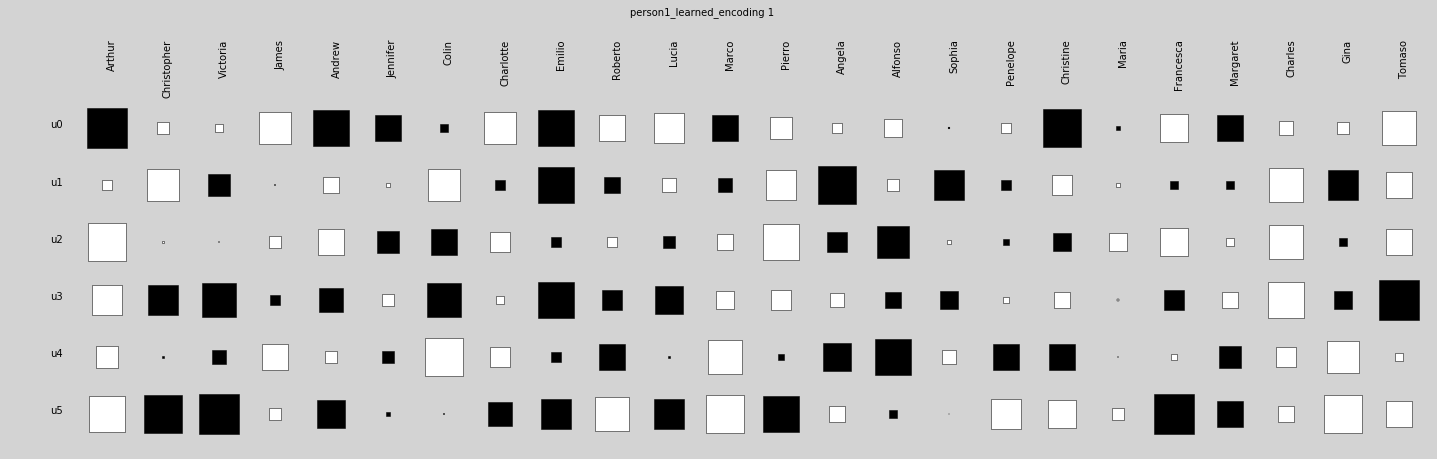

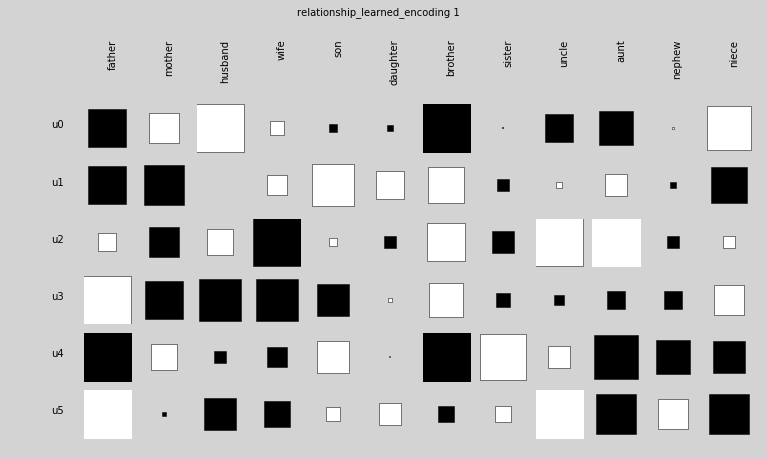

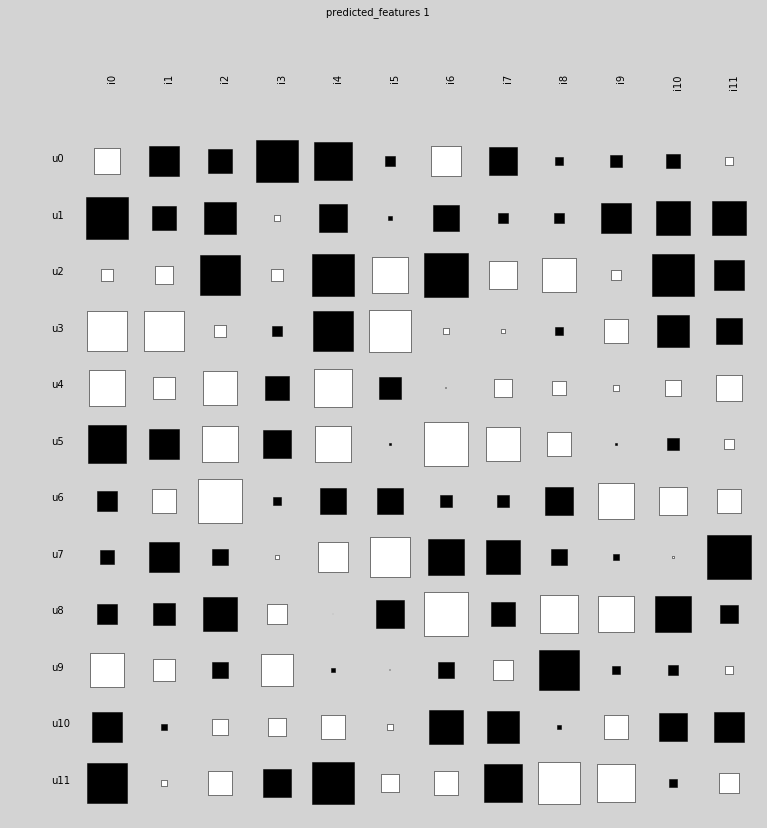

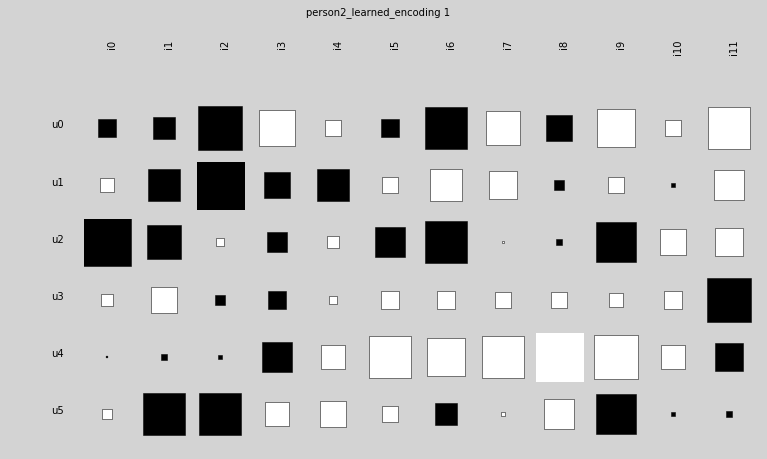

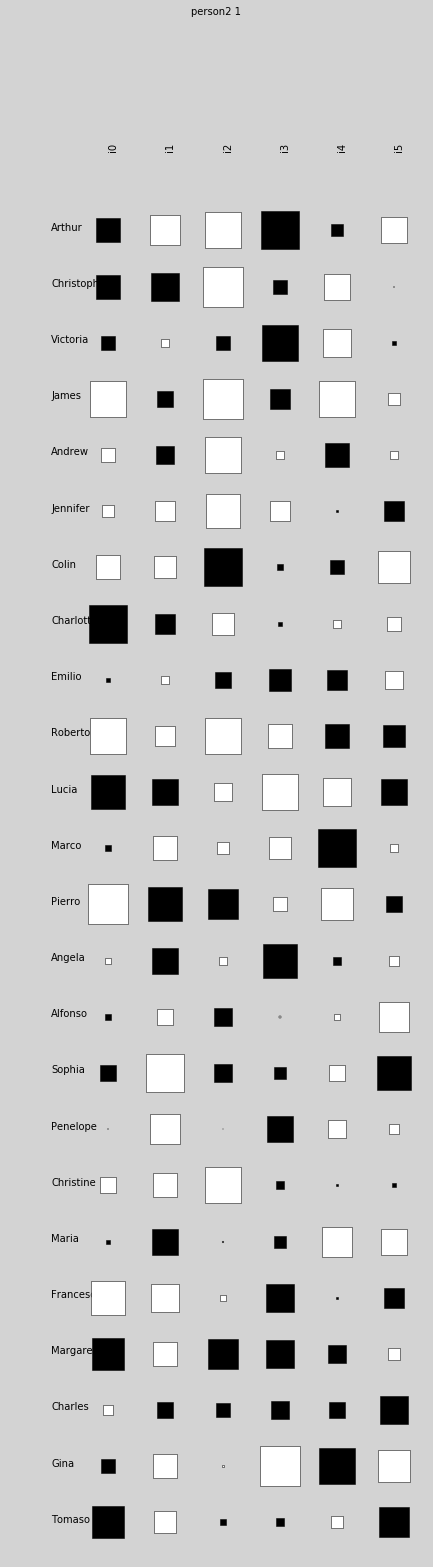

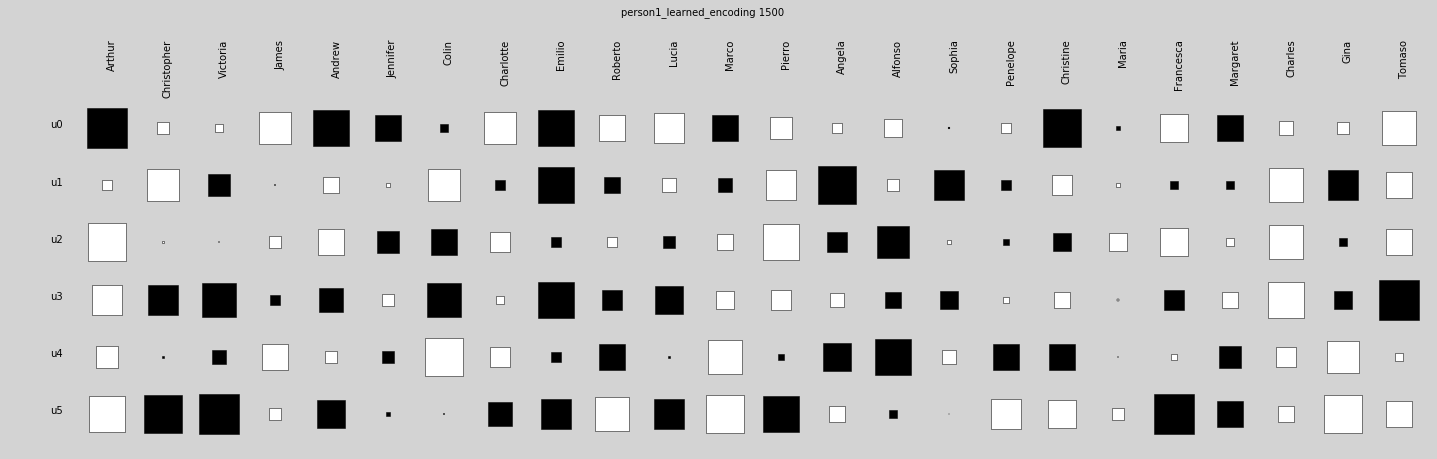

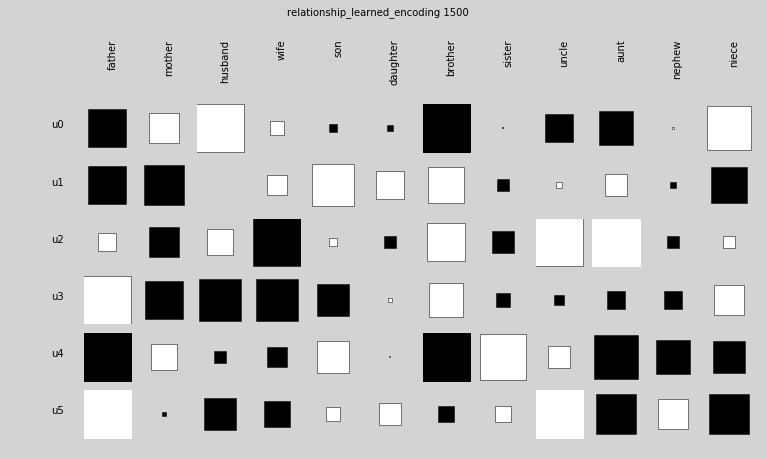

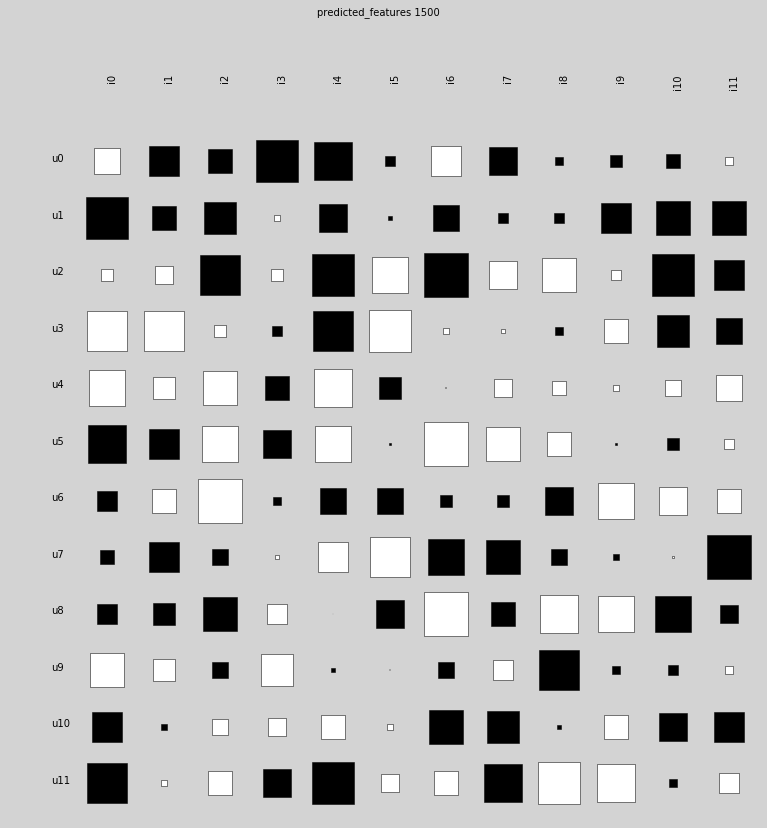

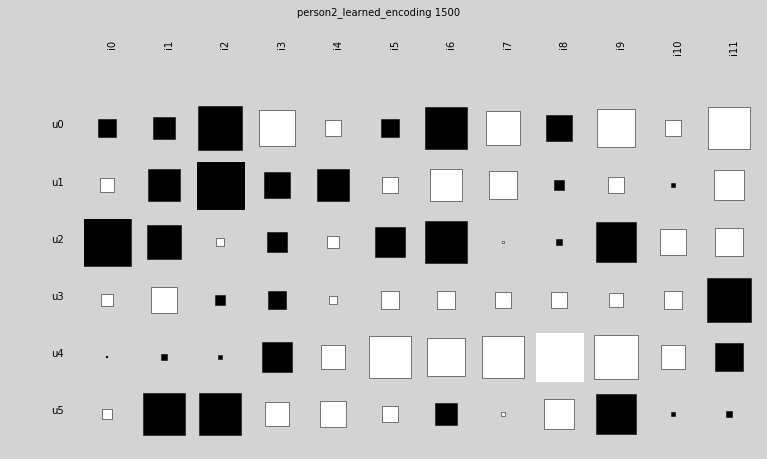

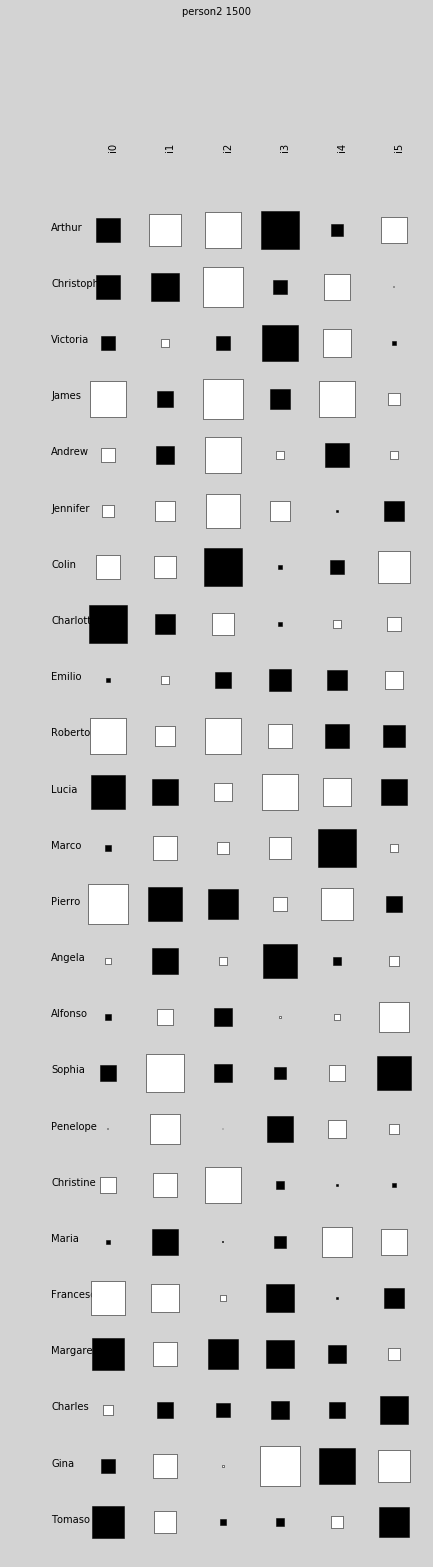

In [16]:
def visualize(weights, title=None, unit_labels=None, input_labels=None):
    num_units = len(weights[0][0])
    num_inputs = len(weights[0])

    if input_labels is None:
        input_labels = []
        for n in range(0, num_inputs):
            input_labels.append("i{0}".format(n))

    if unit_labels is None:
        unit_labels = []
        for n in range(0, num_units):
            unit_labels.append("u{0}".format(n))

    fig, axes = plt.subplots(ncols=num_inputs + 1, nrows=num_units + 1, figsize=(num_inputs + 1, num_units + 1)) # +1 header
    fig.patch.set_facecolor("lightgray")
    
    # upper left corner; always blank
    ax = axes[0][0]
    ax.set_axis_off()                                    
    
    for n, input_label in enumerate(input_labels):
        ax = axes[0][n + 1]
        ax.text(.5, 1, input_label, rotation="vertical")
        ax.set_axis_off()
        
    for i, unit_index in enumerate(range(0, num_units)):
        ax = axes[i + 1][0]
        ax.text(.5, .5, unit_labels[i])
        ax.set_axis_off()                                
        for j, w in enumerate(weights[0]):
            ax = axes[i + 1][j + 1]
            markersize = abs(w[unit_index]) * 90 # will only work for sigmoid (0 to 1 range)
            if w[unit_index] < 0:
                color="black"
            else:
                color="white"
            ax.plot(i, marker="s", markersize=markersize, linestyle=':', color=color)
            ax.margins(0.2)
            ax.set_axis_off()

    if title:
        plt.suptitle(title)

class Peek(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 0 or epoch == self.params['nb_epoch'] - 1:
            visualize(self.model.nodes["person1_learned_encoding"].get_weights(), title="person1_learned_encoding {0}".format(epoch + 1), input_labels=people)
            visualize(self.model.nodes["relationship_learned_encoding"].get_weights(), title="relationship_learned_encoding {0}".format(epoch + 1), input_labels=relationships)
            visualize(self.model.nodes["predicted_features"].get_weights(), title="predicted_features {0}".format(epoch + 1))
            visualize(self.model.nodes["person2_learned_encoding"].get_weights(), title="person2_learned_encoding {0}".format(epoch + 1))
            visualize(self.model.nodes["person2"].get_weights(), title="person2 {0}".format(epoch + 1), unit_labels=people)
            
history = graph.fit({'person1':X_person1, 'relationship':X_relationship, 'output':y_person2}, 
                    verbose=0, batch_size=n, validation_split=0.035398, nb_epoch=1500, callbacks=[Peek()])

In [17]:
predictions = graph.predict({'person1':X_person1, 'relationship':X_relationship})

In [18]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for i, row in enumerate(self):
            html.append("<tr>")
            for col in row:
                if i == 0:
                    html.append("<th>{0}</th>".format(col))                    
                else:
                    html.append("<td>{0}</td>".format(col))
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

table = ListTable()
header = ['person1', 'relationship', 'person2']
header.extend(people)
table.append(header)

for i, prediction in enumerate(predictions['output']):
    person1 = people[X_person1[i].tolist().index(1)]
    relationship = relationships[X_relationship[i].tolist().index(1)]
    person2 = people[y_person2[i].tolist().index(1)]
    row = [person1, relationship, person2]
    row.extend(prediction)
    table.append(row)    

table

person1,relationship,person2,Arthur,Christopher,Victoria,James,Andrew,Jennifer,Colin,Charlotte,Emilio,Roberto,Lucia,Marco,Pierro,Angela,Alfonso,Sophia,Penelope,Christine,Maria,Francesca,Margaret,Charles,Gina,Tomaso
Arthur,father,Christopher,0.0381920360279,0.038911994396,0.035326662251,0.0658589520211,0.0400626753622,0.0546776998068,0.0453171676607,0.0343282001136,0.0307302974053,0.0530221843533,0.0404775828233,0.039544740616,0.0487172564791,0.0298476003762,0.0483217504733,0.0360710019146,0.0484684248947,0.0529551802309,0.0468402536397,0.0428741747536,0.0254175864337,0.0246596179464,0.047545591094,0.0318313689267
Victoria,father,Christopher,0.038205962155,0.0388802051443,0.0354025722477,0.065474336886,0.0399783287964,0.0544761086983,0.0454679579486,0.0344204844515,0.0308398291468,0.0527354446144,0.0405390186865,0.0396084783703,0.0486943658593,0.0298549845769,0.0485092374963,0.0361409577211,0.0484835253327,0.0527453043344,0.0469134929651,0.0427190772587,0.0255837947269,0.0246801728127,0.0477309990736,0.0319153606964
James,father,Andrew,0.0381421109107,0.0388928526411,0.0353255178567,0.0658137447199,0.0400980372287,0.0545398191655,0.0454469862534,0.034354081349,0.0307933562302,0.0529109226103,0.040450314018,0.0395494578663,0.0488347852583,0.0299076467452,0.0484017327456,0.035995469592,0.0484253873826,0.0528385694476,0.0469333712698,0.0428099914141,0.0254560561441,0.0246945573832,0.047608013723,0.0317772180447
Jennifer,father,Andrew,0.0381512086279,0.0389622953946,0.0353839466043,0.0656060870071,0.0400415495798,0.054575944744,0.0452961781681,0.0344226356492,0.0307800206783,0.0528669026938,0.0406292439889,0.0395603734107,0.0487633116093,0.0298820247202,0.0483446691878,0.0361360175758,0.0484118914334,0.0528009473069,0.0468728931957,0.0427750009192,0.0255069139948,0.0247306898014,0.0475707933736,0.0319284603352
Colin,father,James,0.0381693007682,0.0389381340141,0.0353365336251,0.0657811972138,0.0400893809707,0.0545562109793,0.0453803557132,0.0343933981575,0.0307806129883,0.0528883556428,0.0405134766137,0.0395531848171,0.0487772340818,0.0298968785954,0.0483883084934,0.0360175886557,0.0484253585015,0.0528378913517,0.0469314158972,0.042776900114,0.0254617586882,0.0246843961162,0.0476093826469,0.0318127453542
Charlotte,father,James,0.0381316745033,0.0389076758016,0.035353365817,0.0657208835352,0.0400329005714,0.0545383106462,0.0454333418183,0.0343893526548,0.0307801392515,0.0528321357484,0.040547662627,0.0395538172305,0.0488280820383,0.0298575688111,0.0484607040232,0.0360544117177,0.0484496572725,0.052794557047,0.0469576567271,0.0427396311029,0.0254775619916,0.0246619782574,0.0476625884301,0.0318343423761
Emilio,father,Roberto,0.0382436263813,0.038905228761,0.0354072109933,0.065448056641,0.0399441843391,0.0545362146819,0.0453985358529,0.0344391801927,0.030807273519,0.0527442612141,0.0405970943284,0.0396210709222,0.0486047147365,0.0298060782733,0.0485066402963,0.0361858126948,0.0485110477605,0.052779741055,0.0468877206058,0.0426970949937,0.0255778156931,0.0246393826108,0.0477534029191,0.0319586105341
Lucia,father,Roberto,0.038150945428,0.0389005185879,0.0353780971226,0.0655982121366,0.0400564656773,0.0544633714482,0.0454580610168,0.0344059776633,0.0308410925269,0.0527924176654,0.0405127906391,0.0395730764127,0.0488092611294,0.0299201369856,0.0484374111885,0.0360675828461,0.0484206774289,0.0527454736985,0.0469330414463,0.0427599540395,0.0255424177615,0.0247339551217,0.0476414974999,0.0318575645293
Marco,father,Pierro,0.038172990598,0.0389293449454,0.0353171302889,0.0658680431745,0.0400678023848,0.0546666313251,0.0453227863867,0.0343518398036,0.0307234308548,0.052991228197,0.0405184965987,0.0395454189601,0.0487455924361,0.0298404176291,0.048352681461,0.0360453701357,0.0484559327368,0.0529277463437,0.0468821046675,0.0428220935538,0.025408068978,0.0246418321668,0.0475845830419,0.0318184333322
Angela,father,Pierro,0.0381254938231,0.0389351641006,0.0353758806752,0.0655891130065,0.0400664943227,0.0545370504572,0.0453513677299,0.0344100424858,0.